In [134]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats, integrate
from scipy.stats import kendalltau

import warnings
warnings.filterwarnings('ignore')

# %matplotlib notebook

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['font.size'] = 4.0

In [135]:
df_atti = pd.read_pickle('../data/atti.pkl')

# Analysis of the Dataset

From the dataset we can see that:
- there are duplicates for CODICE_PRATICA


In [136]:
df_atti.describe(include='all')

,CODICE_PRATICA,DATA_ATTO,DESCRIZIONE,DESCRIZIONE_TIPO_ATTO,DESCRIZIONE_TIPO_PRATICA,ID_TIPO_PRATICA,LINK_CONTENUTO_BINARIO,OGGETTO,PERSONA,STATUS,UFFICIO_AC,UFFICIO_DG,UFFICIO_SE,publisher
count,184381,184381,184381,184381,184381,184381,184381,184381,183960,184381,184381,184381,184381,184271
unique,184318,4635,16,16,3,3,159577,179195,716,2,369,43,872,18
top,20010036002001AD00000004022,2016-07-19,Atto pubblicato su Banca Dati (PBD),Decreto soggetto a controllo congiunto,Atto dei dirigenti,MON,http://www.regione.toscana.it/bancadati/atti/Contenuto.xml?id=5167177,"L.r. 55/2006 - ""Interventi in favore delle vittime del terrorismo e della criminalità organizzata"" - Assegnazione contributo - Impegno e liquidazione",005549,2,00000,50073,0,iText 2.1.7 by 1T3XT; modified using iText® 5.1.2 ©2000-2011 1T3XT BVBA
freq,2,301,46456,62872,156239,156239,24751,414,8686,184379,53832,15753,36524,57834


In [160]:
df_atti['DATA_ATTO'] = pd.to_datetime(df_atti.DATA_ATTO)

### Duplicates

In [137]:
duplicates = df_atti['CODICE_PRATICA'].value_counts()[df_atti['CODICE_PRATICA'].value_counts() > 1]
print(duplicates.shape)
duplicates[:10]

(63,)


20010036002001AD00000004022        2
20020002002002AD00000000363        2
20120002002012AD00000000345        2
201612270014002016DG00000001749    2
200812010010002008DG00000001377    2
20130002002013AD00000000270        2
201207100006002012DG00000000809    2
20080002002008AD00000000247        2
20060002002006AP0200               2
20000058002000AD00000006214        2
Name: CODICE_PRATICA, dtype: int64

In [138]:
df_atti[df_atti['CODICE_PRATICA'] == '20010036002001AD00000004022']

,CODICE_PRATICA,DATA_ATTO,DESCRIZIONE,DESCRIZIONE_TIPO_ATTO,DESCRIZIONE_TIPO_PRATICA,ID_TIPO_PRATICA,LINK_CONTENUTO_BINARIO,OGGETTO,PERSONA,STATUS,UFFICIO_AC,UFFICIO_DG,UFFICIO_SE,publisher
199,20010036002001AD00000004022,2001-06-19,Atto soggetto a pubblicazione per estratto (PEDP),Decreto soggetto a controllo congiunto,Atto dei dirigenti,MON,http://www.regione.toscana.it/bancadati/atti/Contenuto.xml?id=5167177,"Legge n.457/78 art.36 e Legge 17.2.1992 n.179, art.6 - Determinazione, concessione, impegno e liquidazione del contributo provvisorio in c/capitale alla Impresa Edilizia C.E.T. s.r.l. di Pisa per un intervento di n.12 alloggi nel Comune di Pontedera (PI).",014276,2,01049,01937,0,LibreOffice 5.1
0,20010036002001AD00000004022,2001-06-19,Atto soggetto a pubblicazione per estratto (PEDP),Decreto soggetto a controllo congiunto,Atto dei dirigenti,MON,http://www.regione.toscana.it/bancadati/atti/Contenuto.xml?id=5167177,"Legge n.457/78 art.36 e Legge 17.2.1992 n.179, art.6 - Determinazione, concessione, impegno e liquidazione del contributo provvisorio in c/capitale alla Impresa Edilizia C.E.T. s.r.l. di Pisa per un intervento di n.12 alloggi nel Comune di Pontedera (PI).",014276,2,01049,01937,0,LibreOffice 5.1


We can safely drop all the duplicates

In [139]:
df_atti.drop_duplicates(subset=['CODICE_PRATICA'], inplace=True)

In [140]:
df_atti.shape

(184318, 14)

### Exploration over Uffici

In [141]:
def count_documents_per_office(by):
    df_uffici = pd.read_csv('../data/dg_struttura.csv')
    count_uffici = df_atti[by].value_counts()
    df_uffici['COUNT'] = df_uffici['ID'].apply(
        lambda x: uffici_dirigenziali[str(x)] if str(x) in uffici_dirigenziali.index else 0
    )
    return df_uffici.sort_values(['COUNT'], ascending=False)

In [142]:
df_uffici_dg = count_documents_per_office('UFFICIO_DG')
df_uffici_dg[:10]

,ID,NOME,COUNT
3,50073,D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D,15748
18,50117,DIREZIONE AGRICOLTURA E SVILUPPO RURALE,14059
8,50000,D.G. PRESIDENZA,12439
31,50004,DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI,11510
33,50003,DIREZIONE GENERALE SVILUPPO ECONOMICO,11145
26,50005,DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI,9865
4,50079,D.G. DIRITTI DI CITTADINANZA E COESIONE SOCIALE,7976
19,50118,DIREZIONE AMBIENTE ED ENERGIA,7257
29,50006,"DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT",6788
28,50001,DIREZIONE GENERALE ORGANIZZAZIONE E SISTEMA INFORMATIV,6230


In [143]:
df_uffici_ac = count_documents_per_office('UFFICIO_AC')
df_uffici_ac[:10]

,ID,NOME,COUNT
3,50073,D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D,15748
18,50117,DIREZIONE AGRICOLTURA E SVILUPPO RURALE,14059
8,50000,D.G. PRESIDENZA,12439
31,50004,DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI,11510
33,50003,DIREZIONE GENERALE SVILUPPO ECONOMICO,11145
26,50005,DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI,9865
4,50079,D.G. DIRITTI DI CITTADINANZA E COESIONE SOCIALE,7976
19,50118,DIREZIONE AMBIENTE ED ENERGIA,7257
29,50006,"DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT",6788
28,50001,DIREZIONE GENERALE ORGANIZZAZIONE E SISTEMA INFORMATIV,6230


By comparing the results it looks like the count of the offices from which the offices are dispatched is the same

In [144]:
merged = pd.merge(df_uffici_ac, df_uffici_dg, on=['ID']).drop('NOME_y', axis=1)
merged.sort_values(['ID'])

,ID,NOME_x,COUNT_x,COUNT_y
34,1025,DIPARTIMENTO ORGANIZZAZIONE,0,0
35,1027,DIPARTIMENTO BILANCIO E FINANZE,0,0
33,1923,AVVOCATURA REGIONALE,0,0
39,1928,DIPARTIMENTO PRESIDENZA AFFARI LEGISLATIVI E GIURIDICI,0,0
37,1931,DIPARTIMENTO ORGANIZZAZIONE E RISORSE,0,0
41,1934,DIPARTIMENTO SVILUPPO ECONOMICO,0,0
36,1937,DIPARTIMENTO POLITICHE TERRITORIALI E AMBIENTALI,0,0
40,1943,DIPARTIMENTO SALUTE E POLITICHE SOLIDARIETA,0,0
38,1946,DIPARTIMENTO POLITICHE FORMATIVE E BENI CULTURALI,0,0
42,2090,UFFICI DEL GENIO CIVILE,0,0


### Merge Duplicate Offices

In [145]:
to_replace = {
    '50001': '50115',
    '50069': '50115',
    '50102': '50115',
    '50083': '50004',
    '50079': '50116',
    '50118': '50202',
    '50121': '50201'
}

In [146]:
df_atti['UFFICIO_DG'] = df_atti['UFFICIO_DG'].replace(to_replace)
df_atti['UFFICIO_AC'] = df_atti['UFFICIO_AC'].replace(to_replace)

In [147]:
df_uffici_dg = count_documents_per_office('UFFICIO_DG')
df_uffici_ac = count_documents_per_office('UFFICIO_AC')
merged = pd.merge(df_uffici_ac, df_uffici_dg, on=['ID']).drop('NOME_y', axis=1)
merged

,ID,NOME_x,COUNT_x,COUNT_y
0,50073,D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D,15748,15748
1,50117,DIREZIONE AGRICOLTURA E SVILUPPO RURALE,14059,14059
2,50000,D.G. PRESIDENZA,12439,12439
3,50004,DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI,11510,11510
4,50003,DIREZIONE GENERALE SVILUPPO ECONOMICO,11145,11145
5,50005,DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI,9865,9865
6,50079,D.G. DIRITTI DI CITTADINANZA E COESIONE SOCIALE,7976,7976
7,50118,DIREZIONE AMBIENTE ED ENERGIA,7257,7257
8,50006,"DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT",6788,6788
9,50001,DIREZIONE GENERALE ORGANIZZAZIONE E SISTEMA INFORMATIV,6230,6230


## Check the distribution of the other labels

In [149]:
df_atti.DESCRIZIONE.value_counts()

Atto pubblicato su Banca Dati (PBD)                                                    46452
Atto soggetto a pubblicazione su Banca Dati (PBD)                                      38413
Atto soggetto a pubblicazione per estratto                                             32514
Atto soggetto a pubblicazione integrale (PBURT/BD)                                     14602
Atto soggetto a pubblicazione integrale                                                12181
Atto soggetto a pubblicazione per estratto (PEDP)                                      11271
Diffusione telematica                                                                   9601
Atto non soggetto a pubblicità                                                          5818
Atto pubblicato su BURT e Banca Dati (PBURT/PBD)                                        5811
Atto non soggetto a pubblicazione su Banca Dati (NP)                                    1996
Atto riservato escluso da pubblicità (RE)                             

In [150]:
df_atti.DESCRIZIONE_TIPO_ATTO.value_counts()

Decreto soggetto a controllo congiunto              62854
Decreto non soggetto a controllo interno            54674
Decreto soggetto a solo controllo contabile         30998
Delibera                                            23370
Decreto soggetto a solo controllo amministrativo     7663
Decreto del Presidente                               3670
Proposta di deliberazione al C.R.                     407
Decisione                                             257
Ordinanza del Presidente                              223
Proposta di legge                                     152
Decisione di controllo                                 35
Proposta di regolamento                                 5
Documento preliminare                                   5
Regolamento interno                                     2
                                                        2
Proposta di risoluzione al C.R.                         1
Name: DESCRIZIONE_TIPO_ATTO, dtype: int64

In [133]:
df_atti.DESCRIZIONE_TIPO_PRATICA.value_counts()

Atto dei dirigenti     156239
Atto della giunta       24243
Atto del presidente      3899
Name: DESCRIZIONE_TIPO_PRATICA, dtype: int64

In [151]:
df_atti.PERSONA.value_counts()

005549                       8684
020411                       4578
void                         3894
005045                       3816
015534                       3806
007505                       3113
014002                       2653
013692                       2121
005642                       2013
005070                       1943
017792                       1886
013910                       1743
007108                       1619
005595                       1613
014867                       1584
007115                       1579
020074                       1567
014233                       1563
015654                       1532
1111                         1530
005737                       1495
002157                       1458
1209                         1430
001398                       1408
016472                       1382
005720                       1314
014115                       1301
012608                       1237
008430                       1219
014063        

In [152]:
df_atti.STATUS.value_counts()

2     184317
41         1
Name: STATUS, dtype: int64

### Name the offices

In [153]:
df_atti.columns

Index(['CODICE_PRATICA', 'DATA_ATTO', 'DESCRIZIONE', 'DESCRIZIONE_TIPO_ATTO',
       'DESCRIZIONE_TIPO_PRATICA', 'ID_TIPO_PRATICA', 'LINK_CONTENUTO_BINARIO',
       'OGGETTO', 'PERSONA', 'STATUS', 'UFFICIO_AC', 'UFFICIO_DG',
       'UFFICIO_SE', 'publisher'],
      dtype='object')

## Data Exploration

As first step we want visualize the distrubition of the acts per:
- year
- employee
- office
    
### Acts Per Year

In [162]:
def label_rotation(ax, angle):
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    return ax

In [163]:
df = df_atti

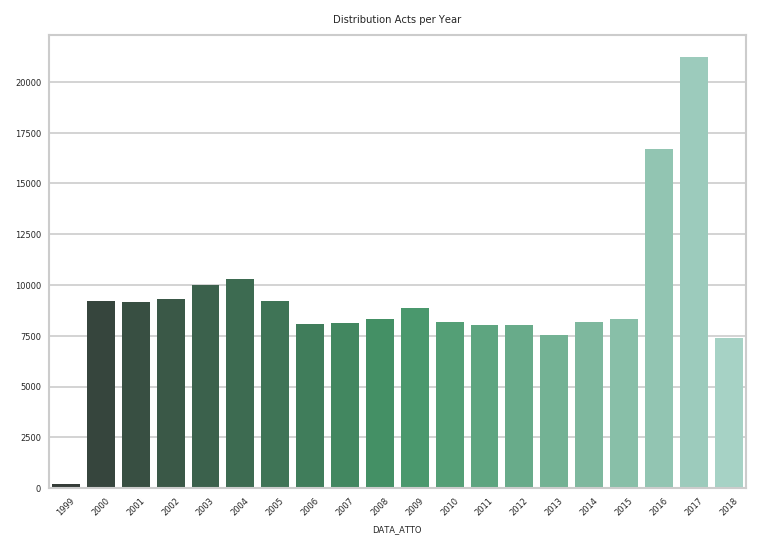

In [168]:
acts_per_year = df.groupby([df['DATA_ATTO'].dt.year])['CODICE_PRATICA'].count()

fig, ax = plt.subplots()
sns.barplot(acts_per_year.index, acts_per_year.values, palette="BuGn_d", ax=ax)
label_rotation(ax, 45)
plt.title('Distribution Acts per Year')
plt.show(fig)

The distribution of the acts per year shows that there is an increase of acts for the years 2016 and 2017.
This is because in 2016 there was a grouping of the regional districts.

From another point of view is interesting to see the distribution of acts per person.

### Acts Per Employee

acts distribution per person


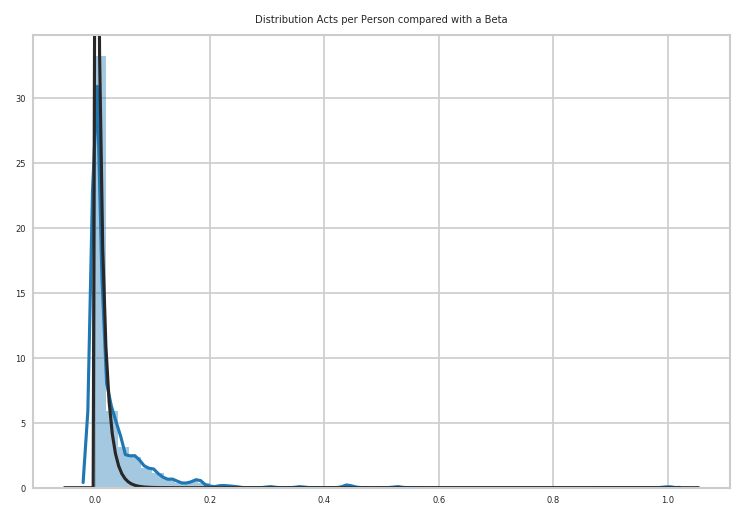

In [171]:
print('acts distribution per person')
acts_per_person = df.groupby([df['PERSONA']])['CODICE_PRATICA'].count().sort_values(ascending=False)

acts_per_person_scaled = (acts_per_person - acts_per_person.min()) / (acts_per_person.max() - acts_per_person.min())

fig, ax = plt.subplots()
sns.distplot(acts_per_person_scaled.values, kde=True, rug=False, ax=ax, fit=stats.beta)
plt.title('Distribution Acts per Person compared with a Beta')
plt.show()

### Distribution of Acts per Office

from here we can see what are the most active offices

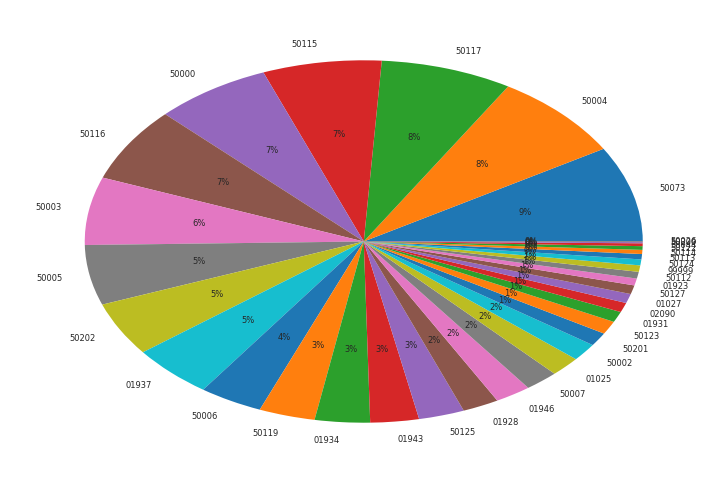

In [180]:
df_act_office = df.groupby(df['UFFICIO_DG'])['CODICE_PRATICA'].count()
df_act_office /= df_act_office.sum()
top = df_act_office.sort_values(ascending=False)
plt.pie(top, labels=top.index, autopct='%1.f%%')
plt.show()

In [182]:
df_uffici.sort_values('COUNT', ascending=False)[:33]

,ID,NOME,COUNT
3,50073,D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D,15748
18,50117,DIREZIONE AGRICOLTURA E SVILUPPO RURALE,14059
8,50000,D.G. PRESIDENZA,12439
31,50004,DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI,11510
33,50003,DIREZIONE GENERALE SVILUPPO ECONOMICO,11145
26,50005,DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI,9865
4,50079,D.G. DIRITTI DI CITTADINANZA E COESIONE SOCIALE,7976
19,50118,DIREZIONE AMBIENTE ED ENERGIA,7257
29,50006,"DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT",6788
28,50001,DIREZIONE GENERALE ORGANIZZAZIONE E SISTEMA INFORMATIV,6230


In [188]:
group_office_year = df.groupby(by=[df['UFFICIO_DG'], df['DATA_ATTO'].dt.year])['CODICE_PRATICA'].count()

As final exploration it would be interesting to see for the top person what is the distributions of acts per year

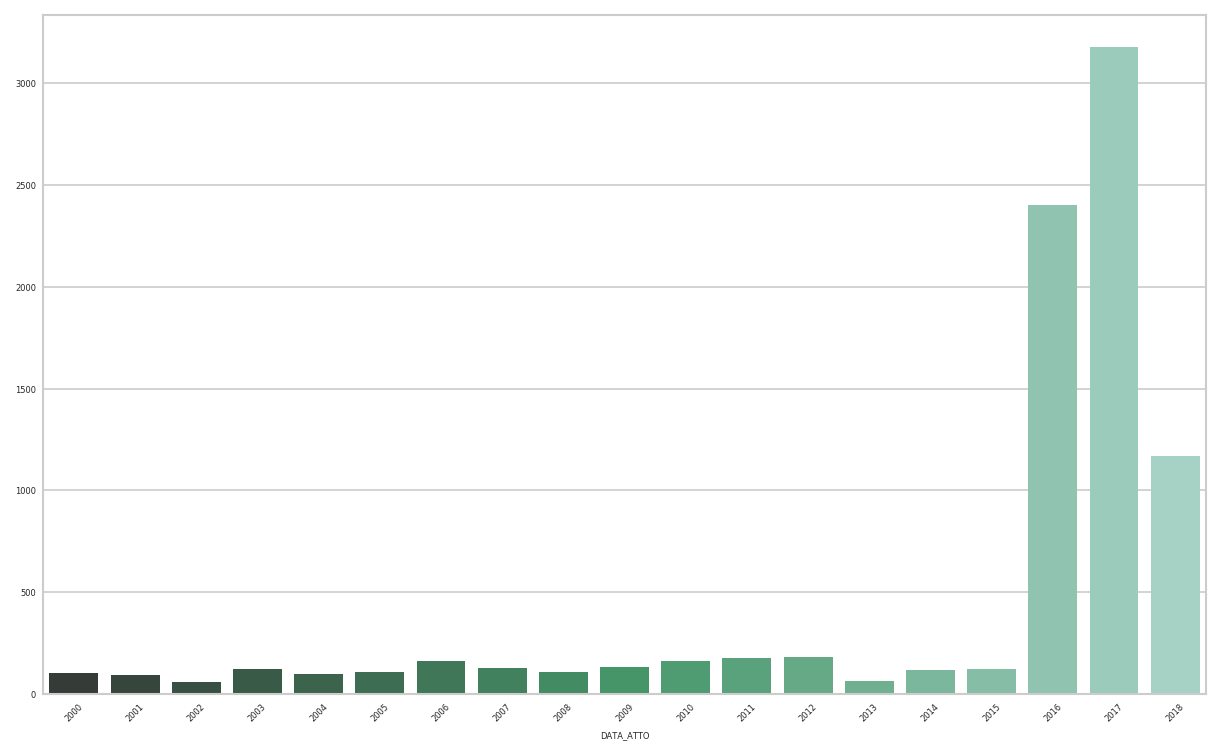

In [191]:
df_person = df[df['PERSONA'] == '005549']
acts_per_year_person = df_person.groupby([df_person['DATA_ATTO'].dt.year])['CODICE_PRATICA'].count()

fig, ax = plt.subplots()
sns.barplot(acts_per_year_person.index, acts_per_year_person.values, palette="BuGn_d", 
            ax=ax, order=acts_per_year_person.index)
label_rotation(ax, 45)
fig.set_size_inches(10,6)
plt.show(fig)

Moreover, we can see that he works for different offices

In [193]:
df_person = df[df['PERSONA'] == '005549']
df_person[['UFFICIO_DG', ].unique()

array(['01934', '99999', '50003', '50073', '50117'], dtype=object)

Here we can see that apart 2016 and 2017 this person did in average the same number of acts.

It would be interesting to see the contribution of each person per office in order to spot:
- when a person moves from one office to another
- Who is in charge of an office (considering that if a person is in charge sign more acts than the others)

## Next Step

After the data exploration the next steps of this notebook is to write a classification model able to predict the office that writes the act given the text in the subject (Oggetto) attribute.

In [194]:
df.to_pickle('../data/atti_processed.pkl')